### TODO

Can we quantify how many additional PPIs we get from studying multiple isoforms relative a single isoform?

We would want to use the screening data, filtered by the pairwise test data, I guess.

Would need to distinguish beetween screening with the same clone twice vs two different isoforms?

Plot degree of binding partners vs. fraction of isoforms interacting

In [1]:
import os
from collections import Counter
from pathlib import Path

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from ccsblib import huri

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y2h_isoform_data,
                          load_valid_isoform_clones,
                          load_paralog_pairs,
                          load_ppi_partner_categories,
                          load_tf_families)
from plotting import y2h_ppi_per_paralog_pair_plot

pd.set_option('display.max_columns', 50)

In [4]:
y2h = load_isoform_and_paralog_y2h_data()
isoforms = load_valid_isoform_clones()
pairs = load_paralog_pairs()
ppi = load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=True)

In [8]:
# get jaccard
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table
# group by TF families
from data_loading import load_y1h_pdi_data, load_m1h_activation_data
pdi = load_y1h_pdi_data()
m1h = load_m1h_activation_data()


tf_fam = load_tf_families()
df = pairs_of_isoforms_comparison_table(isoforms,
                                   ppi,
                                   pdi,
                                   m1h)
df['tf_family'] = df['tf_gene_symbol'].map(tf_fam)

In [7]:
from data_loading import load_annotated_6k_collection


tfs = load_annotated_6k_collection()

reading from cache


In [8]:
# ppi vs disorder
# activation vs charge
df['clone_name_a'] = df['clone_acc_a'].map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['clone_name_b'] = df['clone_acc_b'].map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [11]:
# is reference


def delta_n_D_or_E(row):
    if row['tf_gene_symbol'] not in tfs:
        return np.nan
    aa_ref = tfs[row['tf_gene_symbol']][row['clone_name_a']].aa_seq
    aa_alt = tfs[row['tf_gene_symbol']][row['clone_name_b']].aa_seq
    return  (aa_alt.count('D') + aa_alt.count('E')) - (aa_ref.count('D') + aa_ref.count('E'))

df['delta_n_D_or_E'] = df.apply(delta_n_D_or_E, axis=1)

(0.009783262351005914, 0.808986600824308)


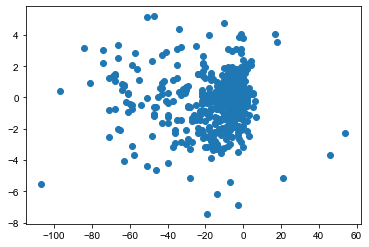

In [22]:
fig, ax = plt.subplots(1, 1)
y, x = df.loc[:, ['activation_fold_change', 'delta_n_D_or_E']].dropna().values.T
ax.scatter(x, y)
print(stats.pearsonr(x, y))


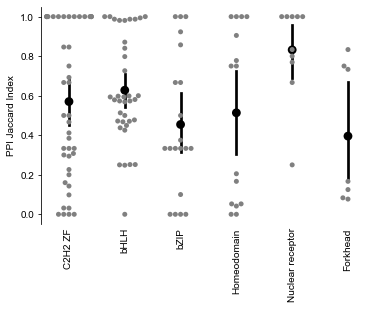

In [9]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df.loc[df['tf_family'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'bZIP', 'Forkhead'])],
              x='tf_family',
              y='ppi_jaccard',
              color='grey',
              ax=ax)
sns.pointplot(data=df.loc[df['tf_family'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'bZIP', 'Forkhead'])],
              x='tf_family',
              y='ppi_jaccard',
              color='black',
              linestyles='',
              ax=ax)
ax.set_ylabel('PPI Jaccard Index')
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.savefig('../figures/PPI-Jaccard_by-TF-family.pdf',
            bbox_inches='tight')

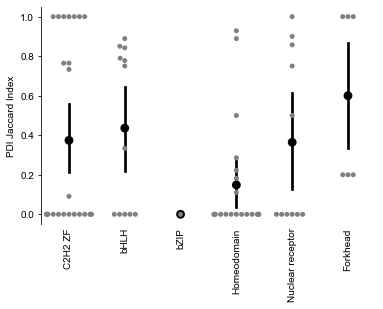

In [32]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df.loc[df['tf_family'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'bZIP', 'Forkhead'])],
              x='tf_family',
              y='pdi_jaccard',
              color='grey',
              ax=ax)
sns.pointplot(data=df.loc[df['tf_family'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'bZIP', 'Forkhead'])],
              x='tf_family',
              y='pdi_jaccard',
              color='black',
              linestyles='',
              ax=ax)
ax.set_ylabel('PDI Jaccard Index')
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.savefig('../figures/PDI-Jaccard_by-TF-family.pdf',
            bbox_inches='tight')

In [11]:
ppi['tf_family_ad'] = ppi['ad_gene_symbol'].map(tf_fam)
ppi['tf_family_db'] = ppi['db_gene_symbol'].map(tf_fam)

Text(0.5, 0, '')

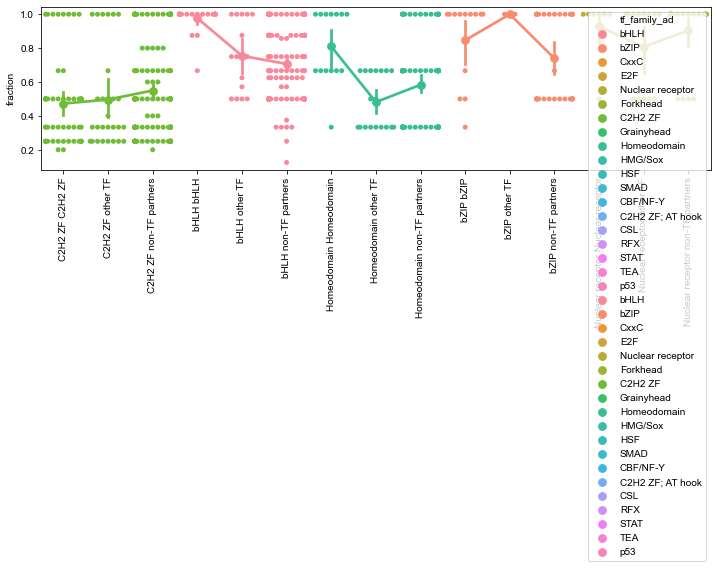

In [34]:
# by tf family
# split partners by within family, other TF, non-tf
# plot fraction of isoforms the partner interacts with?

# change to percent of isoforms loosing PPI?
f =(ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
        ['Y2H_result']
        .mean()
        .to_frame(name='fraction')  # TODO improve name
        .reset_index())
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
f['tf_family_db'] = f['db_gene_symbol'].map(tf_fam)
# consolodate into other families?
fams_to_plot = [
                'C2H2 ZF', 
                'bHLH',
                 'Homeodomain',
                  'bZIP',
                   'Nuclear receptor',
                    #'HMG/Sox',
                    #'Forkhead',
                    #'Grainyhead',
                    #'E2F',
                    ]
f['cat'] = 'Unassigned'
for fam in fams_to_plot:
    f.loc[(f['tf_family_ad'] == fam) & (f['tf_family_db'] == fam), 'cat'] = fam + ' ' + fam
    f.loc[(f['tf_family_ad'] == fam) & (f['tf_family_db'] != fam) & f['tf_family_db'].notnull(), 'cat'] = fam + ' other TF'
    f.loc[(f['tf_family_ad'] == fam) & f['tf_family_db'].isnull(), 'cat'] = fam + ' non-TF partners'


order = [fam + ' ' + x for fam in fams_to_plot for x in [fam, 'other TF', 'non-TF partners']]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=12, h=3)
sns.pointplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
sns.swarmplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

Text(0.5, 0, '')

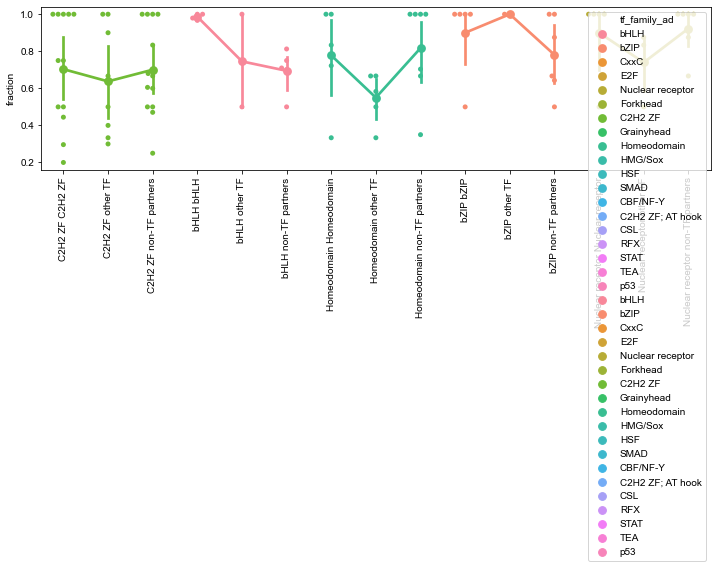

In [38]:
# average over gene
f = f.groupby(['ad_gene_symbol', 'cat'])['fraction'].mean().reset_index()
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
order = [fam + ' ' + x for fam in fams_to_plot for x in [fam, 'other TF', 'non-TF partners']]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=12, h=3)
sns.pointplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
sns.swarmplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

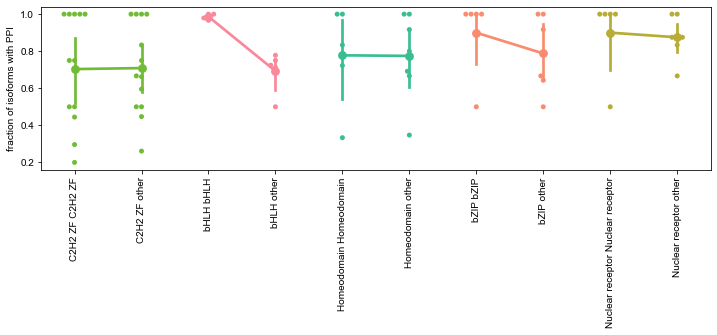

In [43]:
f =(ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
        ['Y2H_result']
        .mean()
        .to_frame(name='fraction')  # TODO improve name
        .reset_index())
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
f['tf_family_db'] = f['db_gene_symbol'].map(tf_fam)
f['cat'] = 'Unassigned'
for fam in fams_to_plot:
    f.loc[(f['tf_family_ad'] == fam) & (f['tf_family_db'] == fam), 'cat'] = fam + ' ' + fam
    f.loc[(f['tf_family_ad'] == fam) & (f['tf_family_db'] != fam) & f['tf_family_db'].notnull(), 'cat'] = fam + ' other'
    f.loc[(f['tf_family_ad'] == fam) & f['tf_family_db'].isnull(), 'cat'] = fam + ' other'

f = f.groupby(['ad_gene_symbol', 'cat'])['fraction'].mean().reset_index()
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
order = [fam + ' ' + x for fam in fams_to_plot for x in [fam, 'other']]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=12, h=3)
sns.pointplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
sns.swarmplot(data=f, x='cat', y='fraction', ax=ax, order=order, hue='tf_family_ad')
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('fraction of isoforms with PPI')
ax.get_legend().remove()
fig.savefig('../figures/pct-isoforms-PPI_by-family.pdf', bbox_inches='tight')
# lose legend
# lose error bar
# add p-value

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/sta

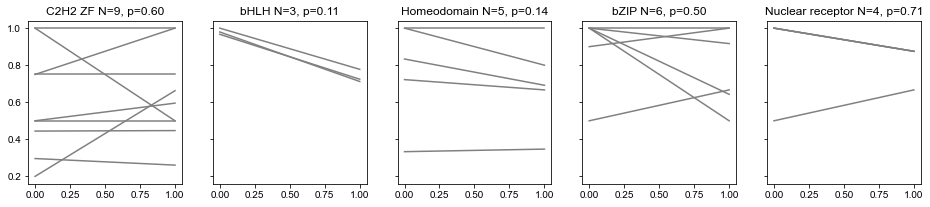

In [100]:
# find bHLH that have both bHLH and other partner
# take average fraction of bHLH and fraction of other partner lost
f =(ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
        ['Y2H_result']
        .mean()
        .to_frame(name='fraction')  # TODO improve name
        .reset_index())
f['tf_family_ad'] = f['ad_gene_symbol'].map(tf_fam)
f['tf_family_db'] = f['db_gene_symbol'].map(tf_fam)
f['same_family'] = (f['tf_family_ad'] == f['tf_family_db'])
f = f.groupby(['ad_gene_symbol', 'same_family', 'tf_family_ad'])['fraction'].mean().reset_index()

f = f.pivot(values='fraction', columns=['same_family'], index=['ad_gene_symbol', 'tf_family_ad'])
f = f.dropna().reset_index().rename(columns={True: 'same family', False: 'different partner'})

fig, axs = plt.subplots(1, len(fams_to_plot), sharey=True)
fig.set_size_inches(w=16, h=3)

for fam, ax in zip(fams_to_plot, axs):
    pairs = f.loc[f['tf_family_ad'] == fam, ['same family', 'different partner']].values
    for pair in pairs:
        ax.plot([0, 1], 
                pair,
                color='grey')
    ax.set_title(f'{fam} N={pairs.shape[0]}, p={stats.wilcoxon(pairs[:, 0], pairs[:, 1])[1]:.2f}')

In [96]:
# p-value, n
stats.wilcoxon(pairs[:, 0], pairs[:, 1])

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=4.0, pvalue=0.7054569861112734)

In [ ]:
# to get p-value
# for each gene calculate mean of TF-TF dimer PPI interacting isoforms - mean of other PPI interacting isoforms
# take mean of that difference
# simulate by shuffling partner names

In [15]:
y2h.loc[(y2h['ad_gene_symbol'].map(tf_fam) == 'Nuclear receptor') & (y2h['db_gene_symbol'].map(tf_fam) == 'Nuclear receptor'), 'ad_gene_symbol'].unique()

array(['RXRA', 'HNF4A', 'RARG', 'RXRG', 'NR1H3', 'PPARD', 'RARB', 'PPARG',
       'RXRB', 'ESRRA', 'ESRRG', 'NR4A2', 'NR4A1', 'RARA', 'NR2F2', 'VDR',
       'NR3C1', 'RORC'], dtype=object)

In [17]:
y2h.loc[(y2h['ad_gene_symbol'].map(tf_fam) == 'bZIP') & (y2h['db_gene_symbol'].map(tf_fam) == 'bZIP'), 'ad_gene_symbol'].unique()

array(['ATF2', 'FOS', 'FOSB', 'NFE2L2', 'DDIT3', 'CREB5'], dtype=object)

In [3]:
print(ppi.loc[ppi['score'].isin(['0', '1']), :].shape[0])
print(ppi.loc[ppi['score'] == '1', :].shape[0])
print(ppi.loc[ppi['score'].isin(['0', '1']), 'ad_clone_acc'].nunique())
print(ppi.loc[ppi['score'].isin(['0', '1']), 'ad_gene_symbol'].nunique())
print(ppi.loc[ppi['score'].isin(['0', '1']), 'db_gene_symbol'].nunique())

3007
1943
159
61
539


In [8]:
# rewiring fraction
df = ppi.copy()
df['score'] = df['score'].map({'1': 1,
                               '0': 0,
                               'AA': np.nan,
                               'NC': np.nan})
partners = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['score']
              .mean()
              .reset_index()
              .groupby('db_gene_symbol')
              .mean()
              .rename(columns={'score': 'rewiring_score'}))
partners['rewiring_score'] = 1. - partners['rewiring_score']
partners['rewiring_score_alt'] = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['score']
                                    .all()
                                    .reset_index()
                                    .groupby('db_gene_symbol')
                                    .mean())
partners['rewiring_score_alt'] = 1. - partners['rewiring_score_alt']
partners['degree'] = (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())
partners['degree_filtered'] = (df.loc[(df['score'] == 1),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())
cats = load_ppi_partner_categories()
cats = cats.groupby('category')['partner'].apply(set).to_dict()
for cat, members in cats.items():
    partners['is_partner_category_' + '_'.join(cat.split())] = partners.index.isin(members)
if partners.isnull().any().any():
    raise ValueError('Did not expect missing data')

In [26]:
ubq = huri.load_ubq_genes()
id_map = (huri.load_id_map('ensembl_gene_id', 'hgnc_symbol')
          .drop_duplicates('ensembl_gene_id')
          .set_index('ensembl_gene_id')
          ['hgnc_symbol'])
ubq = {k: {id_map[g] for g in v} for k, v in ubq.items()}
[(k, partners.index.isin(v).sum()) for k, v in ubq.items()]
partners['is_partner_category_E3_UBQ'] = partners.index.isin(ubq['E3_adaptor'].union(ubq['E3_activity']))
partners['is_partner_category_UBQ'] = partners.index.isin(set.union(*ubq.values()))

kinases = pd.read_html('../data/external/KinHub.htm')[0]['HGNC Name'].unique()
partners['is_partner_category_kinase'] = partners.index.isin(kinases)

In [11]:
partners.head()

rewiring_score  rewiring_score_alt  degree  degree_filtered  \
db_gene_symbol                                                                
A1CF                  0.500000            1.000000       1                1   
ACOT12                0.750000            1.000000       2                1   
AEBP2                 0.333333            1.000000       1                1   
AES                   0.369048            0.857143      14                7   
AGR2                  0.500000            1.000000       1                1   

                is_partner_category_DNA_polymerase  \
db_gene_symbol                                       
A1CF                                         False   
ACOT12                                       False   
AEBP2                                        False   
AES                                          False   
AGR2                                         False   

                is_partner_category_DNA_repair  \
db_gene_symbol                                   
A1CF                                     False   
ACOT12                                   False   
AEBP2                                    False   
AES                                      False   
AGR2                                     False   

                is_partner_category_DNA_replication  \
db_gene_symbol                                        
A1CF                                          False   
ACOT12                                        False   
AEBP2                                         False   
AES                                           False   
AGR2                                          False   

                is_partner_category_RNA_processing  \
db_gene_symbol                                       
A1CF                                          True   
ACOT12                                       False   
AEBP2                                        False   
AES                                          False   
AGR2                                         False   

                is_partner_category_RNA_turnover  is_partner_category_TF  \
db_gene_symbol                                                             
A1CF                                       False                   False   
ACOT12                                     False                   False   
AEBP2                                      False                    True   
AES                                        False                   False   
AGR2                                       False                   False   

                is_partner_category_cell_cycle  \
db_gene_symbol                                   
A1CF                                     False   
ACOT12                                   False   
AEBP2                                    False   
AES                                      False   
AGR2                                     False   

                is_partner_category_cell-cell_signaling  \
db_gene_symbol                                            
A1CF                                              False   
ACOT12                                            False   
AEBP2                                             False   
AES                                               False   
AGR2                                              False   

                is_partner_category_cofactor  \
db_gene_symbol                                 
A1CF                                   False   
ACOT12                                 False   
AEBP2                                  False   
AES                                     True   
AGR2                                   False   

                is_partner_category_cytoskeleton  \
db_gene_symbol                                     
A1CF                                       False   
ACOT12                                     False   
AEBP2                                      False   
AES                                        False   
AGR2                

                    rewiring_score  rewiring_score_alt
rewiring_score            1.000000            0.872146
rewiring_score_alt        0.872146            1.000000


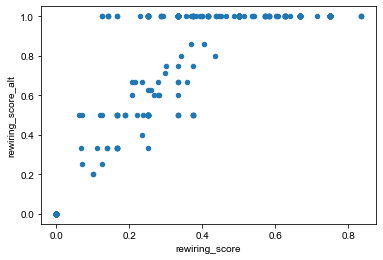

In [12]:
print(partners[['rewiring_score', 'rewiring_score_alt']].corr())
partners.plot.scatter(x='rewiring_score', y='rewiring_score_alt')

In [27]:
cat_columns = [c for c in partners.columns if c.startswith('is_partner_category_')]
partners[cat_columns].sum().sort_values(ascending=False)

is_partner_category_TF                     144
is_partner_category_cofactor                88
is_partner_category_signaling               67
is_partner_category_other                   49
is_partner_category_UBQ                     47
is_partner_category_E3_UBQ                  41
is_partner_category_RNA_processing          32
is_partner_category_cytoskeleton            29
is_partner_category_protein_turnover        26
is_partner_category_metabolism              26
is_partner_category_vesicle_transport       23
is_partner_category_cell_cycle              22
is_partner_category_kinase                  19
is_partner_category_DNA_repair              16
is_partner_category_cell-cell_signaling      9
is_partner_category_translation              8
is_partner_category_RNA_turnover             6
is_partner_category_membrane_protein         3
is_partner_category_DNA_polymerase           3
is_partner_category_nuclear_transport        2
is_partner_category_DNA_replication          2
is_partner_ca

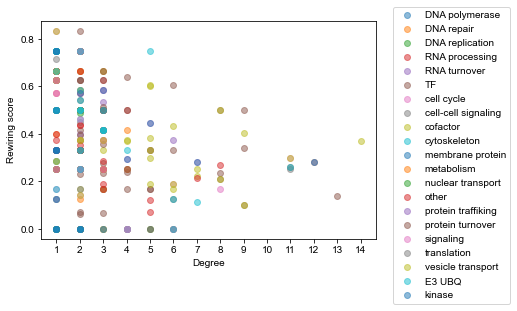

In [14]:
fig, ax = plt.subplots(1, 1)
# order categories by size
for cat in cat_columns:
    ax.scatter(partners.loc[partners[cat],
                             'degree'],
                partners.loc[partners[cat],
                             'rewiring_score'],
               label=cat[len('is_partner_category_'):].replace('_', ' '),
               alpha=0.5)
ax.set_xticks(range(1, partners['degree'].max() + 1))
ax.set_xlabel('Degree')
ax.set_ylabel('Rewiring score')
ax.legend(loc=[1.05, -0.3])

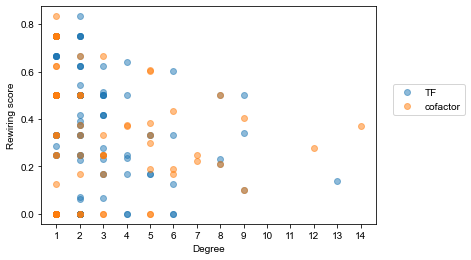

In [15]:
fig, ax = plt.subplots(1, 1)
# order categories by size
min_partners = 75
for cat in cat_columns:
    if partners[cat].sum() < min_partners:
        continue
    ax.scatter(partners.loc[partners[cat],
                             'degree'],
                partners.loc[partners[cat],
                             'rewiring_score'],
               label=cat[len('is_partner_category_'):].replace('_', ' '),
               alpha=0.5)
ax.set_xticks(range(1, partners['degree'].max() + 1))
ax.set_xlabel('Degree')
ax.set_ylabel('Rewiring score')
ax.legend(loc=[1.05, 0.5])

In [16]:
# TEMP: take KRTAPs out of cytoskeleton
# TODO: fix the file
partners.loc[partners.index.str.startswith('KRTAP'), 'is_partner_category_cytoskeleton'] = False
partners.loc[partners.index.str.startswith('KRTAP'), 'is_partner_category_other'] = True

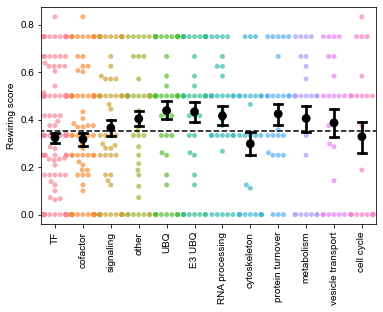

In [28]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_category.pdf',
            bbox_inches='tight')

In [53]:
id_map

ensembl_gene_id
ENSG00000210049        MT-TF
ENSG00000211459      MT-RNR1
ENSG00000210077        MT-TV
ENSG00000210082      MT-RNR2
ENSG00000209082       MT-TL1
                     ...    
ENSG00000284208         NCR1
ENSG00000284279    RNU6-222P
ENSG00000283827      KIR3DL1
ENSG00000283846      KIR2DS4
ENSG00000283951      KIR3DL2
Name: hgnc_symbol, Length: 40583, dtype: object

In [72]:
def load_reactome_gene_to_pathway():
    """Ensemble Gene IDs -> lowest level reactome pathways
    Returns:
        pandas.DataFrame: one row per gene/pathway combination
    """
    pth = Path('../data/external/Ensembl2Reactome_All_Levels.txt')
    data = pd.read_csv(pth,
                       sep='\t',
                       names=['ensembl_id',
                              'reactome_pathway_id',
                              'url',
                              'pathway_name',
                              'evidence_code',
                              'species'])
    data = (data.loc[data['ensembl_id'].str.startswith('ENSG') &
                     (data['species'] == 'Homo sapiens'),
                     ['ensembl_id',
                      'reactome_pathway_id',
                      'pathway_name',
                      'evidence_code']]
                .rename(columns={'ensembl_id': 'ensembl_gene_id'}))
    return data

In [76]:
reactome = load_reactome_gene_to_pathway()
reactome['hgnc_gene_symbol'] = reactome['ensembl_gene_id'].map(id_map)
for pathway_name, count in reactome['pathway_name'].value_counts().iteritems():
    if count >= 20:
        pathway_genes = reactome.loc[reactome['pathway_name'] == pathway_name, 
                                    'hgnc_gene_symbol'].unique()
        partners['is_partner_pathway_' + pathway_name] = partners.index.isin(pathway_genes)

In [77]:
pathway_columns = [c for c in partners.columns if c.startswith('is_partner_pathway_')]
partners[pathway_columns].sum().sort_values(ascending=False)

is_partner_pathway_Gene expression (Transcription)                                           85
is_partner_pathway_Signal Transduction                                                       77
is_partner_pathway_RNA Polymerase II Transcription                                           76
is_partner_pathway_Generic Transcription Pathway                                             69
is_partner_pathway_Metabolism of proteins                                                    63
                                                                                             ..
is_partner_pathway_Inactivation, recovery and regulation of the phototransduction cascade     0
is_partner_pathway_Netrin-1 signaling                                                         0
is_partner_pathway_Endosomal/Vacuolar pathway                                                 0
is_partner_pathway_HSF1 activation                                                            0
is_partner_pathway_Interleukin-27 signal

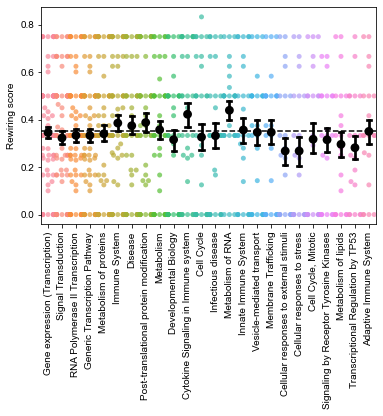

In [78]:
x = partners.loc[:, pathway_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_pathway_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_pathway.pdf',
            bbox_inches='tight')

In [82]:
# subcellular location

subcell = huri.load_subcellular_location()
subcell['hgnc_symbol'] = subcell.index.map(id_map)
subcell = subcell.groupby('hgnc_symbol').any()
for compartment in subcell.columns:
    compartment_genes = subcell[subcell[compartment]].index.values
    partners['is_partner_compartment_' + compartment[3:]] = partners.index.isin(compartment_genes)

In [84]:
compartment_columns = [c for c in partners.columns if c.startswith('is_partner_compartment_')]
partners[compartment_columns].sum().sort_values(ascending=False)

is_partner_compartment_Nucleoplasm                      156
is_partner_compartment_Cytosol                          153
is_partner_compartment_Nucleus                           77
is_partner_compartment_Plasma membrane                   47
is_partner_compartment_Nucleoli                          42
is_partner_compartment_Vesicles                          41
is_partner_compartment_Nuclear speckles                  29
is_partner_compartment_Nuclear bodies                    20
is_partner_compartment_Mitochondria                      17
is_partner_compartment_Golgi apparatus                   16
is_partner_compartment_Intermediate filaments            10
is_partner_compartment_Cell Junctions                    10
is_partner_compartment_Centrosome                         9
is_partner_compartment_Microtubules                       7
is_partner_compartment_Microtubule organizing center      6
is_partner_compartment_Nucleoli fibrillar center          6
is_partner_compartment_Actin filaments  

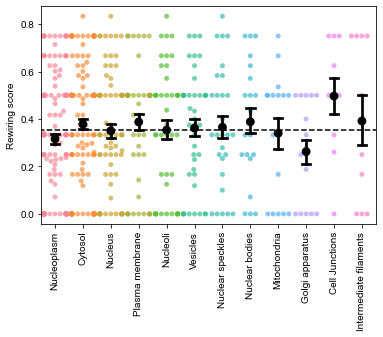

In [85]:
x = partners.loc[:, compartment_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_compartment_'):].replace('_', ' '))
min_n_category = 10
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_subcellular_compartment.pdf',
            bbox_inches='tight')

In [100]:
# gene age
age = huri.load_gene_age().to_frame()
age['hgnc_symbol'] = age.index.map(id_map)
age = age.dropna()
age = age.drop_duplicates('hgnc_symbol')
age = age.set_index('hgnc_symbol')['gene_age']

Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?


In [101]:
for age_category in age.unique():
    genes_list = age[age == age_category].index.values
    partners['is_partner_age_' + age_category] = partners.index.isin(genes_list)

Index(['Mammalia', 'Vertebrata', 'Eumetazoa', 'Opisthokonta', 'Eukaryota',
       'Euk+Bac', 'Euk_Archaea', 'Cellular_organisms'],
      dtype='object')

In [106]:
age_columns = ['is_partner_age_' + c for c in age.dtype.categories]
partners[age_columns].sum().sort_values(ascending=False)

is_partner_age_Eukaryota             168
is_partner_age_Eumetazoa             164
is_partner_age_Vertebrata             62
is_partner_age_Mammalia               40
is_partner_age_Opisthokonta           39
is_partner_age_Euk+Bac                28
is_partner_age_Cellular_organisms     23
is_partner_age_Euk_Archaea             7
dtype: int64

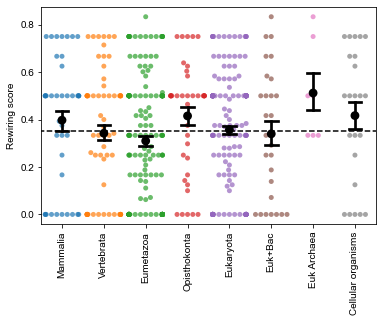

In [111]:
x = partners.loc[:, age_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_age_'):].replace('_', ' '))
min_n_category = 0
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=[c.replace('_', ' ') for c in age.dtype.categories],
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=[c.replace('_', ' ') for c in age.dtype.categories],
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_subcellular_gene_age.pdf',
            bbox_inches='tight')

In [115]:
def load_cancer_driver_gene_compendium():
    """
    From intogen.org
    Martinez-Jimenez et al. Nature Reviews Cancer, 2020
    """
    return set(pd.read_csv('../data/external/Compendium_Cancer_Genes.tsv', sep='\t')['SYMBOL'].unique())

cdg = load_cancer_driver_gene_compendium()

In [117]:
def load_cancer_gene_census():
    return set(pd.read_csv('../data/external/cancer_gene_census.csv')['Gene Symbol'].values)

cgc = load_cancer_gene_census()
len(cgc)

723

In [118]:
len(cgc.intersection(cdg))

416

In [122]:
def load_omim_genes():
    omim = pd.read_table('../data/external/OMIM_genemap2.txt',
                         names=['Chromosome',
                                'Genomic Position Start',
                                'Genomic Position End',
                                'Cyto Location',
                                'Computed Cyto Location',
                                'Mim Number',
                                'Gene Symbols',
                                'Gene Name',
                                'Approved Symbol',
                                'Entrez Gene ID',
                                'Ensembl Gene ID',
                                'Comments',
                                'Phenotypes',
                                'Mouse Gene Symbol/ID'],
                         comment='#')
    # the file contains all genes, so filter for those
    # with disease annotation
    return set(omim.loc[omim['Phenotypes'].notnull() & omim['Approved Symbol'].notnull(), 'Approved Symbol'].unique())


omim = load_omim_genes()

4407

In [ ]:
# MGI essentiality



In [127]:
partners['is_partner_disease_OMIM'] = partners.index.isin(omim)
partners['is_partner_disease_Cancer_Gene_Census'] = partners.index.isin(cgc)
partners['is_partner_disease_Cancer_Driver_Compendium'] = partners.index.isin(cdg)

In [132]:
disease_columns = [c for c in partners.columns if c.startswith('is_partner_disease_')]
partners[disease_columns].sum().sort_values(ascending=False)

is_partner_disease_OMIM                        128
is_partner_disease_Cancer_Gene_Census           34
is_partner_disease_Cancer_Driver_Compendium     30
dtype: int64

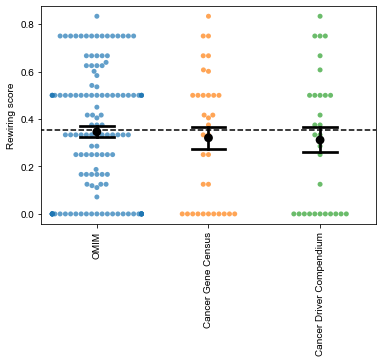

In [133]:
x = partners.loc[:, disease_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_disease_'):].replace('_', ' '))
min_n_category = 10
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_disease.pdf',
            bbox_inches='tight')

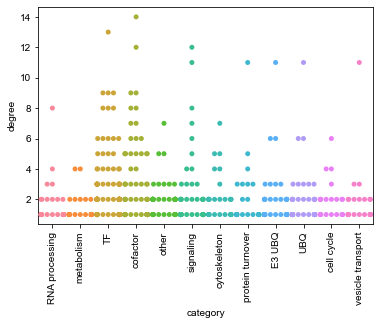

In [31]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['degree'] = x.index.map(partners['degree'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['degree'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='degree',
              ax=ax)
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90);

In [32]:
partners['rewiring_score_alt'].mean()

0.688612068203905

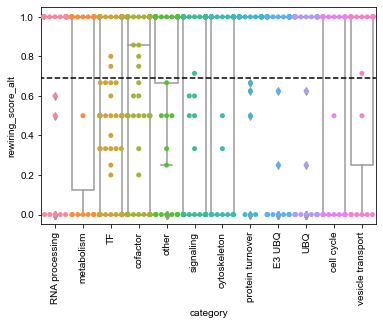

In [33]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score_alt'] = x.index.map(partners['rewiring_score_alt'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score_alt'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=x,
              x='category',
              y='rewiring_score_alt',
               color='white',
             ax=ax)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score_alt',
              ax=ax)
ax.axhline(y=partners['rewiring_score_alt'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90);

In [34]:
df = pd.read_excel('../data/internal/20191028- Uniprot functions for interactors.xlsx',
                   sheet_name='Final')
df = df.loc[df['Cofactor type?'].notnull(), ['partner', 'Cofactor type?']]
if df['partner'].duplicated().any():
    raise UserWarning('unexpected duplicates')
cf_type = df.set_index('partner')['Cofactor type?']
x['cofactor_type'] = x.index.map(cf_type)

In [35]:
x[x.category == 'metabolism']

category  rewiring_score_alt cofactor_type
db_gene_symbol                                              
ACOT12          metabolism                 1.0           NaN
ATP5O           metabolism                 1.0           NaN
ATP6V1B2        metabolism                 1.0           NaN
ATPAF2          metabolism                 0.0           NaN
CBS             metabolism                 1.0           NaN
COA5            metabolism                 1.0           NaN
COX5B           metabolism                 0.0           NaN
FLAD1           metabolism                 1.0           NaN
FUCA1           metabolism                 0.0           NaN
GLYCTK          metabolism                 1.0           NaN
GYS1            metabolism                 0.5           NaN
HSD3B7          metabolism                 1.0           NaN
IMPDH1          metabolism                 1.0           NaN
KHK             metabolism                 1.0           NaN
MSRB3           metabolism                 0.0           NaN
NDOR1           metabolism                 1.0           NaN
NEU4            metabolism                 1.0           NaN
NGB             metabolism                 1.0           NaN
NME7            metabolism                 1.0           NaN
NUDT10          metabolism                 1.0           NaN
NUDT22          metabolism                 0.0           NaN
OPLAH           metabolism                 1.0           NaN
PMM2            metabolism                 1.0           NaN
SLC39A13        metabolism                 1.0           NaN
TSTD2           metabolism                 0.0           NaN
WAC             metabolism                 0.0   coactivator

In [36]:
for cat_col in cat_columns:
    print('{}: {:.4f}'.format(
          cat_col[len('is_partner_category_'):].replace('_', ' '),
          stats.mannwhitneyu(partners.loc[partners[cat_col], 'rewiring_score'].values,
                             partners.loc[~partners[cat_col], 'rewiring_score'].values)[1]))

DNA polymerase: 0.2849
DNA repair: 0.4103
DNA replication: 0.4595
RNA processing: 0.0885
RNA turnover: 0.0308
TF: 0.0658
cell cycle: 0.3741
cell-cell signaling: 0.1420
cofactor: 0.0657
cytoskeleton: 0.1042
membrane protein: 0.3972
metabolism: 0.1171
nuclear transport: 0.2935
other: 0.0646
protein traffiking: 0.0000
protein turnover: 0.0988
signaling: 0.3357
translation: 0.0946
vesicle transport: 0.2353
E3 UBQ: 0.0157
kinase: 0.2059
UBQ: 0.0072


In [4]:
tf_fam = load_tf_families()

In [135]:
tf_fam.value_counts()

C2H2 ZF         747
Homeodomain     196
bHLH            108
Unknown          69
bZIP             54
               ... 
TCR/CxC           1
Brinker           1
MBD; CxxC ZF      1
Ets; AT hook      1
CBF/NF-Y          1
Name: DBD, Length: 65, dtype: int64

In [225]:
tf_fam.loc[tf_fam == 'E2F']

HGNC symbol
E2F1     E2F
E2F2     E2F
E2F3     E2F
E2F4     E2F
E2F5     E2F
E2F6     E2F
E2F7     E2F
E2F8     E2F
TFDP1    E2F
TFDP2    E2F
TFDP3    E2F
Name: DBD, dtype: object

In [8]:
tf_fam.loc[tf_fam == 'Rel']

HGNC symbol
NFAT5     Rel
NFATC1    Rel
NFATC2    Rel
NFATC3    Rel
NFATC4    Rel
NFKB1     Rel
NFKB2     Rel
REL       Rel
RELA      Rel
RELB      Rel
Name: DBD, dtype: object

In [157]:
partners['DBD'] = partners.index.map(tf_fam)

In [158]:
partners.DBD.value_counts()

C2H2 ZF                 44
bHLH                    23
Homeodomain             18
bZIP                    10
Unknown                  7
Nuclear receptor         5
HMG/Sox                  4
MBD                      3
SMAD                     3
Homeodomain; POU         3
E2F                      3
Forkhead                 2
Ets                      2
C2H2 ZF; AT hook         2
THAP finger              2
TCR/CxC                  1
BED ZF                   1
Pipsqueak                1
DM                       1
C2H2 ZF; BED ZF          1
RFX                      1
AP-2                     1
TBP                      1
Grainyhead               1
T-box                    1
CENPB                    1
C2H2 ZF; Homeodomain     1
CCCH ZF                  1
Name: DBD, dtype: int64

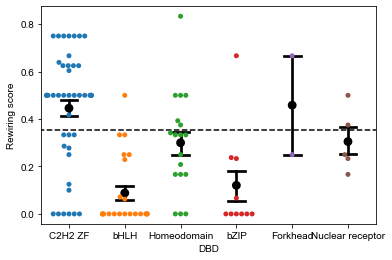

In [159]:
# calculate p-value
dbds_to_plot = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']
partners.loc[partners['DBD'].notnull() & ~partners['DBD'].isin(dbds_to_plot), 'DBD'] = 'Other TFs'
partners.loc[partners['DBD'].isnull(), 'DBD'] = 'Not TF'
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=partners.loc[partners['DBD'].isin(dbds_to_plot), :],
            x='DBD',
            y='rewiring_score',
            order=dbds_to_plot,
            ax=ax)
sns.pointplot(data=partners.loc[partners['DBD'].isin(dbds_to_plot), :],
              x='DBD',
              y='rewiring_score',
              order=dbds_to_plot,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_DBD.pdf',
            bbox_inches='tight')

In [28]:
# how to calculate a p-value?
# randomly change each partner DBD label? 
#    - Doesn't work because a single bHLH TF can interact with many bHLH

In [44]:
tf_fam.head()

HGNC symbol
TFAP2A    AP-2
TFAP2B    AP-2
TFAP2C    AP-2
TFAP2D    AP-2
TFAP2E    AP-2
Name: DBD, dtype: object

In [45]:
# TF-TF binding
tftf = ppi.loc[ppi['score'] == '1', ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
tftf['ad_dbd'] = tftf['ad_gene_symbol'].map(tf_fam)
tftf['db_dbd'] = tftf['db_gene_symbol'].map(tf_fam)
tftf = tftf.dropna()

In [173]:
tftf.head()

ad_gene_symbol db_gene_symbol       ad_dbd       db_dbd
13            TCF4          HOXA1         bHLH  Homeodomain
62             WT1          HOXA1      C2H2 ZF  Homeodomain
72            RFX4          HOXA1          RFX  Homeodomain
204          MEIS2          HOXB5  Homeodomain  Homeodomain
205           PBX1          HOXB5  Homeodomain  Homeodomain

In [178]:
# TF-TF rewiring
tftf = pd.merge(tftf, 
        (ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['score'].apply(lambda x: (x == '0').sum()) / 
 ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['score'].apply(lambda x: (x.isin(['0', '1']).sum()))).reset_index(),
        how='left',
        on=['ad_gene_symbol', 'db_gene_symbol'])

In [46]:
tftf.loc[tftf['db_dbd'] == 'bHLH', 'ad_gene_symbol'].value_counts()

TCF4      16
TCF12     14
ESRRA      2
ARNTL2     2
ARNT2      1
ESRRG      1
IKZF2      1
ZBTB44     1
ZNF438     1
LHX6       1
FOS        1
Name: ad_gene_symbol, dtype: int64

In [47]:
tftf.loc[(tftf['db_dbd'] == 'bHLH') & (tftf['ad_dbd'] == 'bHLH'), 'ad_gene_symbol'].value_counts()

TCF4      16
TCF12     14
ARNTL2     2
ARNT2      1
Name: ad_gene_symbol, dtype: int64

In [48]:
tftf.loc[tftf['db_dbd'] == 'bZIP', 'ad_gene_symbol'].value_counts()

DDIT3     5
ATF2      3
FOSB      2
NFE2L2    2
CREB5     2
NFYA      1
FOS       1
ZNF451    1
Name: ad_gene_symbol, dtype: int64

In [49]:
# exclude TCF4 and TCF12 and recalculate
partners_mod = (df.loc[~df['ad_gene_symbol'].isin(['TCF4', 'TCF12']), :]
              .groupby(['ad_gene_symbol', 'db_gene_symbol'])['score']
              .mean()
              .reset_index()
              .groupby('db_gene_symbol')
              .mean()
              .rename(columns={'score': 'rewiring_score'}))
partners_mod['rewiring_score'] = 1. - partners_mod['rewiring_score']
partners_mod['DBD'] = partners_mod.index.map(tf_fam)

fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=partners_mod.loc[partners_mod['DBD'].isin(['C2H2 ZF', 'bHLH']), :],
            x='DBD',
            y='rewiring_score',
            order=['C2H2 ZF', 'bHLH'],
            ax=ax)
sns.pointplot(data=partners_mod.loc[partners_mod['DBD'].isin(['C2H2 ZF', 'bHLH']), :],
              x='DBD',
              y='rewiring_score',
              order=['C2H2 ZF', 'bHLH'],
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.set_ylabel('Rewiring score')
plt.savefig('../figures/rewiring_score_by_DBD_exclude_TCF4_TCF12.pdf',
            bbox_inches='tight')

stats.mannwhitneyu(partners_mod.loc[partners_mod['DBD'] == 'C2H2 ZF', 'rewiring_score'].values,
                   partners_mod.loc[partners_mod['DBD'] == 'bHLH', 'rewiring_score'].values)[1] * 6

KeyError: 'ad_gene_symbol'

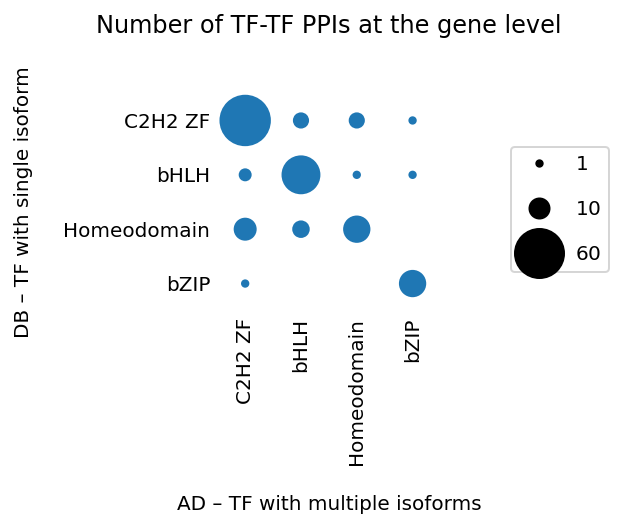

In [73]:
fams = tf_fam.unique()
fams = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 60],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.8, 0.8],
         labelspacing=1.3)
plt.savefig('../figures/TF_TF_correlogram.pdf', bbox_inches='tight')

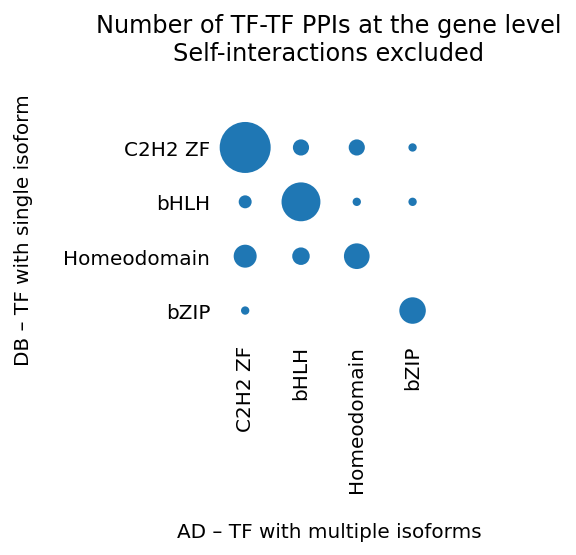

In [74]:
# homodimers excluded
fams = tf_fam.unique()
fams = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 10
ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y) & (tftf['ad_gene_symbol'] != tftf['db_gene_symbol'])).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level\nSelf-interactions excluded',
             pad=30)
plt.savefig('../figures/TF_TF_correlogram_homodimers_excluded.pdf', bbox_inches='tight')

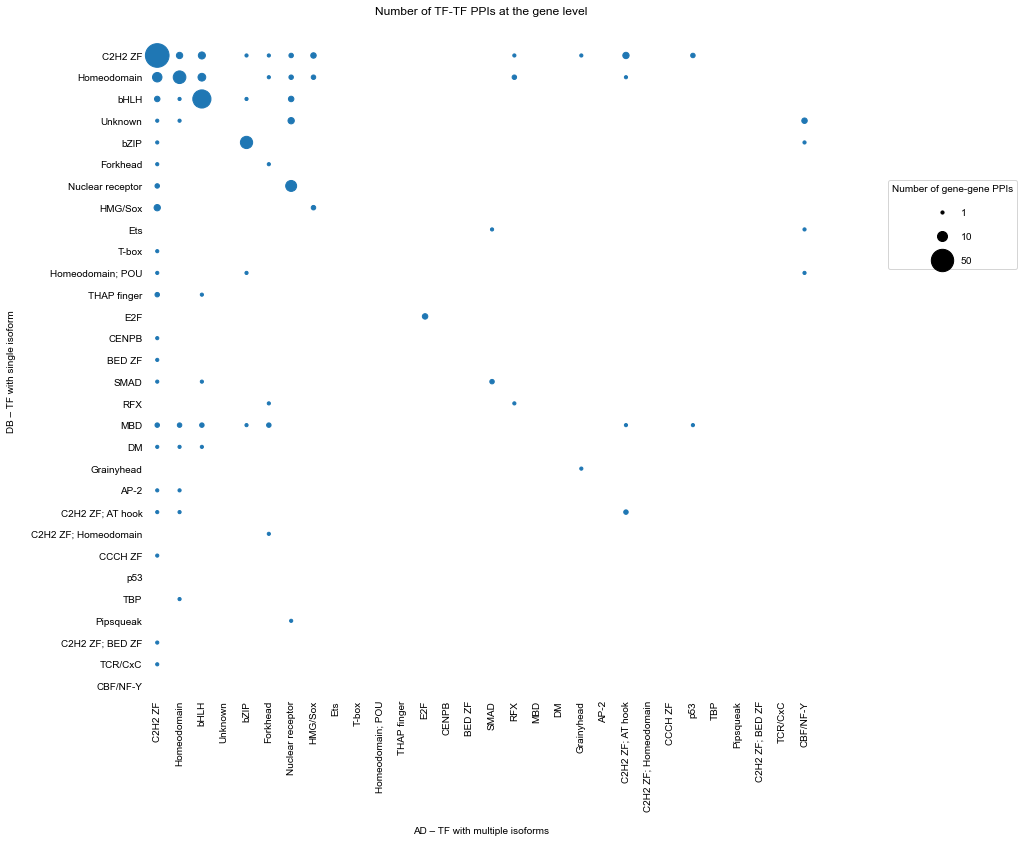

In [145]:
# all families
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 50],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.1, 0.8],
         labelspacing=1.3,
          title='Number of gene-gene PPIs')
plt.savefig('../figures/TF_TF_correlogram_all.pdf', bbox_inches='tight')

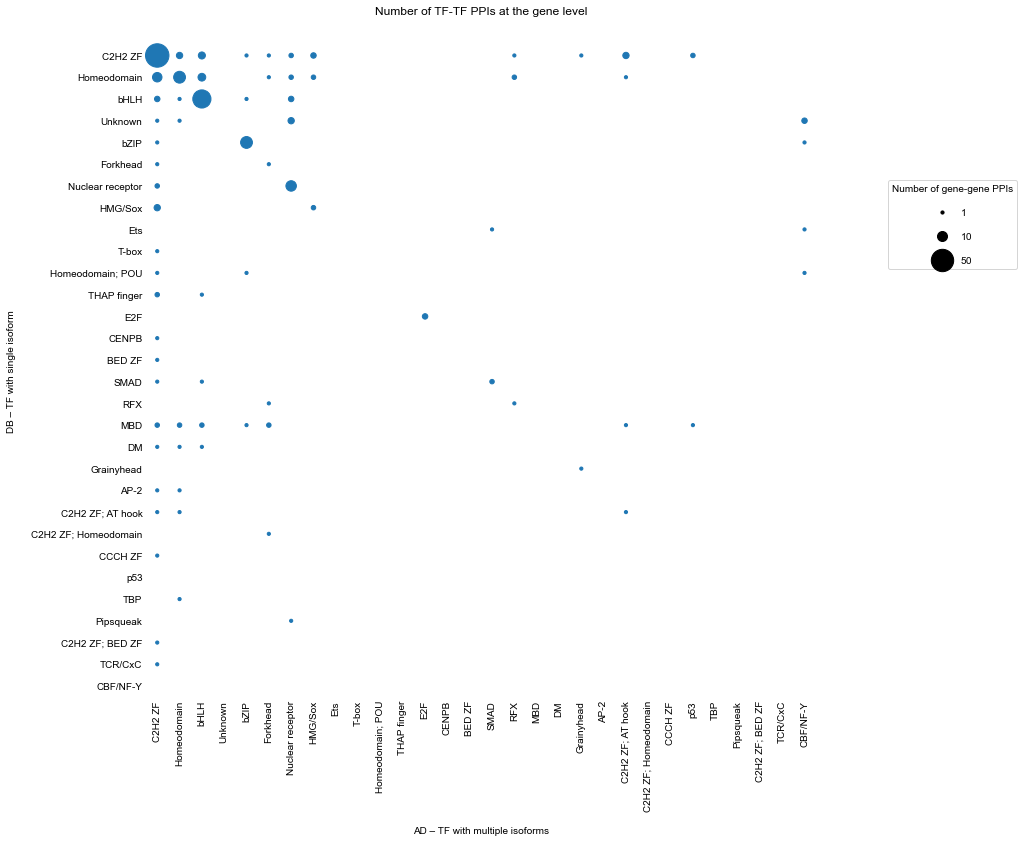

In [147]:
# all families
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y) & (tftf['ad_gene_symbol'] != tftf['db_gene_symbol'])).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 50],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.1, 0.8],
         labelspacing=1.3,
          title='Number of gene-gene PPIs')
plt.savefig('../figures/TF_TF_correlogram_all_no_homodimers.pdf', bbox_inches='tight')

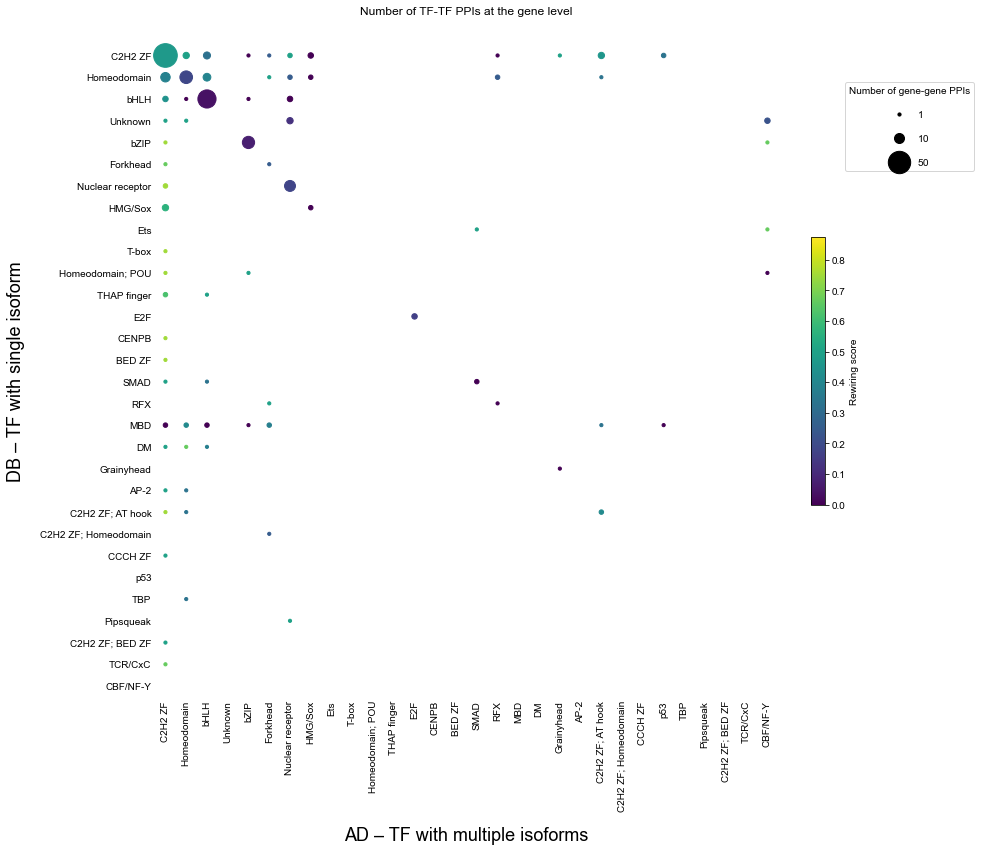

In [219]:
import matplotlib as mpl
# color by rewiring
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() * scaling for x in fams for y in fams],
           c=[tftf.loc[(tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y), 'score'].mean() for x in fams for y in fams],
           cmap='viridis',
           vmin=0,
           vmax=7/8,
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              fontsize=18,
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              fontsize=18,
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 50],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.1, 0.95],
         labelspacing=1.3,
          title='Number of gene-gene PPIs')
fig.colorbar(mpl.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=0, vmax=7/8)),
             ax=ax,
             fraction=0.02,
             label='Rewiring score')
plt.savefig('../figures/TF_TF_correlogram_colored_by_rewiring.pdf', bbox_inches='tight')

In [ ]:
# what are these unknown DBDs? That interact with NRs...

In [76]:
# examples
# ZBTB48
# ZSCAN12
# FIGLA - TCF12, TCF4, LHX6, 
# MSGN1
partners.loc[partners['DBD'] == 'C2H2 ZF', :].sort_values(['rewiring_score', 'degree_filtered'], ascending=[True, False]).head(5)

rewiring_score  rewiring_score_alt  degree  degree_filtered  \
db_gene_symbol                                                                
ZBTB25                     0.0                 0.0       6                3   
ZNF250                     0.0                 0.0       7                3   
IKZF1                      0.0                 0.0       1                1   
YY1                        0.0                 0.0       1                1   
ZBTB2                      0.0                 0.0       1                1   

                is_partner_category_DNA_polymerase  \
db_gene_symbol                                       
ZBTB25                                       False   
ZNF250                                       False   
IKZF1                                        False   
YY1                                          False   
ZBTB2                                        False   

                is_partner_category_DNA_repair  \
db_gene_symbol                                   
ZBTB25                                   False   
ZNF250                                   False   
IKZF1                                    False   
YY1                                      False   
ZBTB2                                    False   

                is_partner_category_DNA_replication  \
db_gene_symbol                                        
ZBTB25                                        False   
ZNF250                                        False   
IKZF1                                         False   
YY1                                           False   
ZBTB2                                         False   

                is_partner_category_RNA_processing  \
db_gene_symbol                                       
ZBTB25                                       False   
ZNF250                                       False   
IKZF1                                        False   
YY1                                          False   
ZBTB2                                        False   

                is_partner_category_RNA_turnover  is_partner_category_TF  \
db_gene_symbol                                                             
ZBTB25                                     False                    True   
ZNF250                                     False                    True   
IKZF1                                      False                    True   
YY1                                        False                    True   
ZBTB2                                      False                    True   

                is_partner_category_cell_cycle  \
db_gene_symbol                                   
ZBTB25                                   False   
ZNF250                                   False   
IKZF1                                    False   
YY1                                      False   
ZBTB2                                    False   

                is_partner_category_cell-cell_signaling  \
db_gene_symbol                                            
ZBTB25                                            False   
ZNF250                                            False   
IKZF1                                             False   
YY1                                               False   
ZBTB2                                             False   

                is_partner_category_cofactor  \
db_gene_symbol                                 
ZBTB25                                 False   
ZNF250                                 False   
IKZF1                                  False   
YY1                                    False   
ZBTB2                                  False   

                is_partner_category_cytoskeleton  \
db_gene_symbol                                     
ZBTB25                                     False   
ZNF250                                     False   
IKZF1                                      False   
YY1                                        False   
ZBTB2               

In [77]:
ppi.loc[ppi['db_gene_symbol'] == 'FIGLA', 'ad_gene_symbol'].unique()

array(['TCF12', 'TCF4', 'LHX6'], dtype=object)

In [78]:
ppi.loc[ppi['db_gene_symbol'] == 'MSGN1', 'ad_gene_symbol'].unique()

array(['TCF4', 'ESRRA', 'TCF12'], dtype=object)

In [79]:
ppi.loc[ppi['db_gene_symbol'] == 'ZSCAN12', 'ad_gene_symbol'].unique()

array(['ZNF451', 'ZNF397'], dtype=object)

In [80]:
# statisitcal test (6 is Bonferonni for all pairwise)
# problem with this is that the points are not necessarily indepedent: could all be binding to same TF
stats.mannwhitneyu(partners.loc[partners['DBD'] == 'C2H2 ZF', 'rewiring_score'].values,
                   partners.loc[partners['DBD'] == 'bHLH', 'rewiring_score'].values)[1] * 6

3.491707433580842e-06

In [81]:
stats.mannwhitneyu(partners.loc[(partners['DBD'] == 'C2H2 ZF')
                                & (partners['degree'] == 1),
                                'rewiring_score'].values,
                   partners.loc[(partners['DBD'] == 'bZIP')
                                 & (partners['degree'] == 1),
                                'rewiring_score'].values)

MannwhitneyuResult(statistic=19.5, pvalue=0.034154173044924664)

In [82]:
partners.head()

rewiring_score  rewiring_score_alt  degree  degree_filtered  \
db_gene_symbol                                                                
A1CF                  0.500000            1.000000       1                1   
ACOT12                0.750000            1.000000       2                1   
AEBP2                 0.333333            1.000000       1                1   
AES                   0.369048            0.857143      14                7   
AGR2                  0.500000            1.000000       1                1   

                is_partner_category_DNA_polymerase  \
db_gene_symbol                                       
A1CF                                         False   
ACOT12                                       False   
AEBP2                                        False   
AES                                          False   
AGR2                                         False   

                is_partner_category_DNA_repair  \
db_gene_symbol                                   
A1CF                                     False   
ACOT12                                   False   
AEBP2                                    False   
AES                                      False   
AGR2                                     False   

                is_partner_category_DNA_replication  \
db_gene_symbol                                        
A1CF                                          False   
ACOT12                                        False   
AEBP2                                         False   
AES                                           False   
AGR2                                          False   

                is_partner_category_RNA_processing  \
db_gene_symbol                                       
A1CF                                          True   
ACOT12                                       False   
AEBP2                                        False   
AES                                          False   
AGR2                                         False   

                is_partner_category_RNA_turnover  is_partner_category_TF  \
db_gene_symbol                                                             
A1CF                                       False                   False   
ACOT12                                     False                   False   
AEBP2                                      False                    True   
AES                                        False                   False   
AGR2                                       False                   False   

                is_partner_category_cell_cycle  \
db_gene_symbol                                   
A1CF                                     False   
ACOT12                                   False   
AEBP2                                    False   
AES                                      False   
AGR2                                     False   

                is_partner_category_cell-cell_signaling  \
db_gene_symbol                                            
A1CF                                              False   
ACOT12                                            False   
AEBP2                                             False   
AES                                               False   
AGR2                                              False   

                is_partner_category_cofactor  \
db_gene_symbol                                 
A1CF                                   False   
ACOT12                                 False   
AEBP2                                  False   
AES                                     True   
AGR2                                   False   

                is_partner_category_cytoskeleton  \
db_gene_symbol                                     
A1CF                                       False   
ACOT12                                     False   
AEBP2                                      False   
AES                                        False   
AGR2                

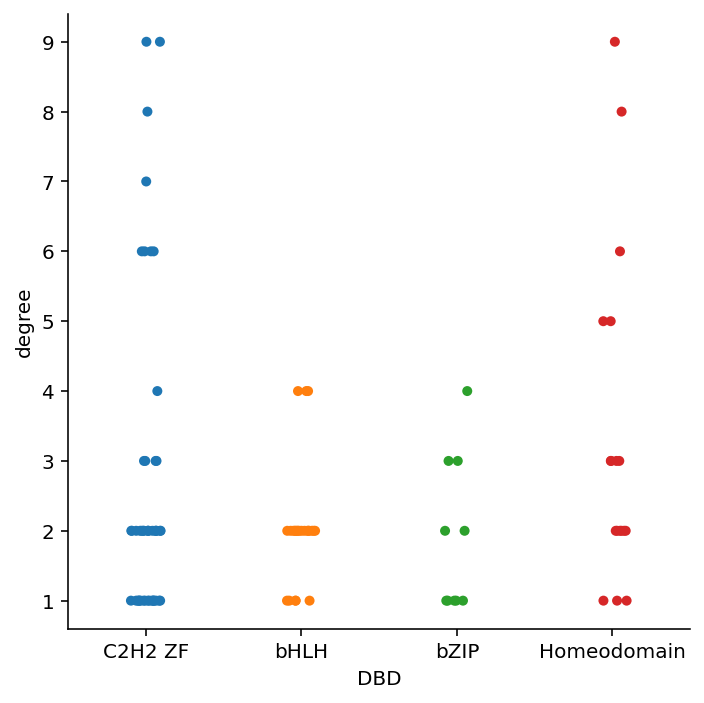

In [83]:
# is it a degree thing?
sns.catplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), :],
            x='DBD', y='degree')

In [84]:
# could take an example of very reqired ZF

In [85]:
# Is it that ZF are more rewired or the others are less, or both?



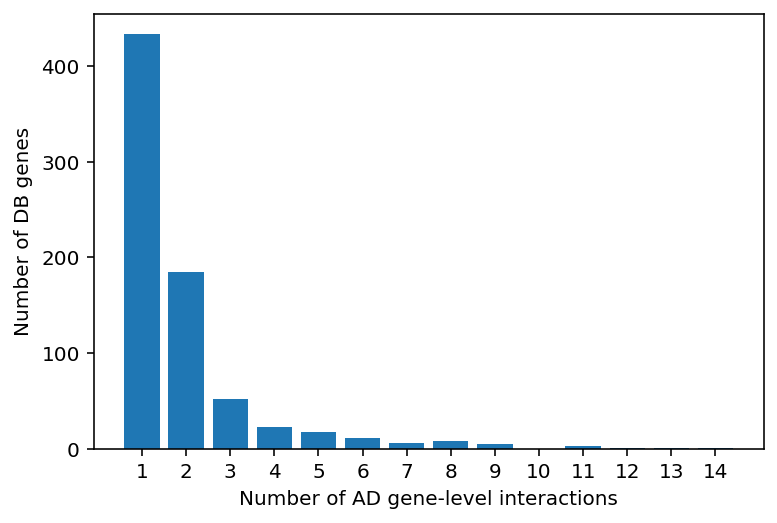

In [86]:
partner_degree = (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())

fig, ax = plt.subplots(1, 1)
db_deg = partner_degree.value_counts()
plt.bar(db_deg.index.values, db_deg.values)
ax.set_xticks(range(1, partner_degree.max() + 1))
ax.set_ylabel('Number of DB genes')
ax.set_xlabel('Number of AD gene-level interactions')
plt.savefig('../figures/DB_gene_level_degree.pdf',
            bbox_inches='tight')

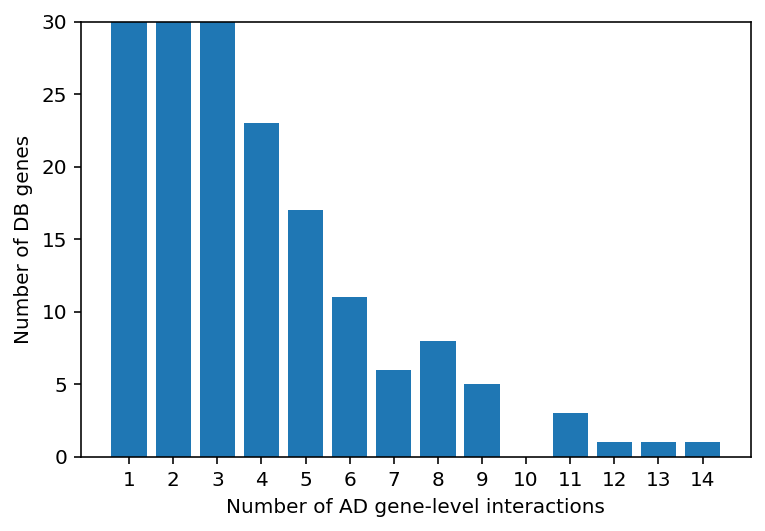

In [87]:
fig, ax = plt.subplots(1, 1)
ax.bar(db_deg.index.values, db_deg.values)
ax.set_xticks(range(1, partner_degree.max() + 1))
ax.set_ylabel('Number of DB genes')
ax.set_xlabel('Number of AD gene-level interactions')
ax.set_ylim(0, 30)
plt.savefig('../figures/DB_gene_level_degree_zoom.pdf',
            bbox_inches='tight')

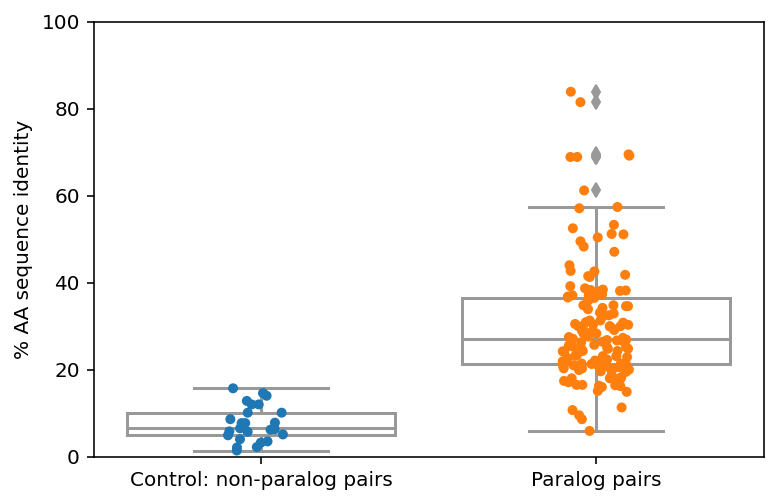

In [88]:
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity')
sns.boxplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity', color='white')
ax.set_ylim(0, 100)
ax.set_ylabel('% AA sequence identity')
ax.set_xticklabels(['Control: non-paralog pairs', 'Paralog pairs'])
ax.set_xlabel('')
plt.savefig('../figures/paralog_nonparalog_aa_identity.pdf',
            bbox_inches='tight')

KeyboardInterrupt: 

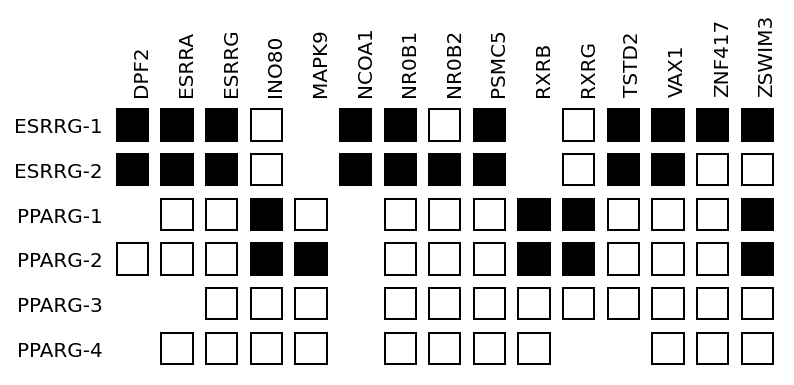

In [89]:
# Takes a long time
for i, row in pairs.iterrows():
    fig, ax = plt.subplots(1, 1)
    a = row['tf_gene_a']
    b = row['tf_gene_b']
    y2h_ppi_per_paralog_pair_plot(a, b, y2h, ax=ax)
    os.makedirs('../figures/paralog_pairs', exist_ok=True)
    plt.savefig('../figures/paralog_pairs/' + a + '_' + b + '.pdf',
                bbox_inches='tight')
    plt.close(fig)

In [90]:
#    - How many partners were negative in all pairwise tests?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].nunique()
print('Of {} tested partners, {} had at least one positive result'.format(a, b))

Of 907 tested partners, 746 had at least one positive result


In [91]:
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].unique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].unique()
c = set(a).difference(set(b))
# remove these interactions where none of the isoforms are positive
y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        y2h['db_gene_symbol'].isin(c), :].head()

category  ad_orf_id     ad_clone_acc ad_gene_symbol  db_orf_id  \
57   tf_isoform_ppis     101216  GATA1|1/2|08A02          GATA1       1579   
103  tf_isoform_ppis     100301  SMAD3|1/4|06A07          SMAD3       1579   
115  tf_isoform_ppis     100697  SMAD3|4/4|06F07          SMAD3       1579   
126  tf_isoform_ppis     100657  SMAD3|2/4|06G07          SMAD3       1579   
138  tf_isoform_ppis     100479  SMAD3|3/4|06B08          SMAD3       1579   

    db_gene_symbol score standard_batch  retest_pla retest_pos  \
57           TEKT4     0          TFr11           1        A07   
103          TEKT4     0          TFr07           2        B01   
115          TEKT4     0          TFr07           2        C01   
126          TEKT4     0          TFr07           2        D01   
138          TEKT4     0          TFr09           1        G06   

     in_orfeome_screen  in_focussed_screen  in_hi_union  in_lit_bm  \
57                True               False         True      False   
103              False               False         True      False   
115              False               False         True      False   
126              False               False         True      False   
138              False               False         True      False   

     is_partner_category_DNA_polymerase  is_partner_category_DNA_repair  \
57                                False                           False   
103                               False                           False   
115                               False                           False   
126                               False                           False   
138                               False                           False   

     is_partner_category_DNA_replication  is_partner_category_RNA_processing  \
57                                 False                               False   
103                                False                               False   
115                                False                               False   
126                                False                               False   
138                                False                               False   

     is_partner_category_RNA_turnover  is_partner_category_TF  \
57                              False                   False   
103                             False                   False   
115                             False                   False   
126                             False                   False   
138                             False                   False   

     is_partner_category_cell_cycle  is_partner_category_cell-cell_signaling  \
57                            False                                    False   
103                           False                                    False   
115                           False                                    False   
126                           False                                    False   
138                           False                                    False   

     is_partner_category_cofactor  is_partner_category_cytoskeleton  \
57                          False                              True   
103                         False                              True   
115                         False                              True   
126                         False                              True   
138                         False                              True   

     is_partner_category_membrane_protein  is_partner_category_metabolism  \
57                                  False                           False   
103                                 False                           False   
115                                 False                           False   
126                                 False                           False   
138                                 False                           False   

     is_partner_category_nuclea

In [92]:
print('Total TF genes with cloned isoforms: {}'.format(isoforms['gene'].nunique()))
print('Total TF genes with 2+ cloned isoforms: {}'.format(sum((isoforms.groupby('gene').count()>1)['clone_acc'])))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['score'] == '1'), 
                                        'ad_gene_symbol'].nunique()))
print('with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: {}'
       .format(
        (((y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   y2h['score'].isin(['0', '1']), 
                   :]
              .groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['ad_clone_acc']
              .nunique() # number of isoforms per partner with valid interactions
              >= 2)
              .reset_index()
              .groupby('ad_gene_symbol').sum() >= 2).sum().iat[0])
     )
)
print('with ≥ 2 isoforms with ≥ 1 PPI each: {}'
       .format(
          (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   (y2h['score'] == '1'), 
                   :]
              .groupby('ad_gene_symbol')
              ['ad_clone_acc']
              .nunique()
              >= 2).sum()  
         )
     )

Total TF genes with cloned isoforms: 312
Total TF genes with 2+ cloned isoforms: 249
with ≥ 1 PPI: 132
with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: 89
with ≥ 2 isoforms with ≥ 1 PPI each: 71


In [93]:
print('Total TF isoforms: {}'.format(isoforms['clone_acc'].nunique()))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['score'] == '1'), 
                                        'ad_clone_acc'].nunique()))
print('with ≥ 1 successfully tested PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                                    y2h['score'].isin(['0', '1']), 
                                                    'ad_clone_acc'].nunique()))

Total TF isoforms: 762
with ≥ 1 PPI: 241
with ≥ 1 successfully tested PPI: 378


In [94]:
ppi.head()

ad_clone_acc ad_gene_symbol db_gene_symbol score
3     TCF4|8/9|07A05           TCF4          HOXA1    NC
4   ZBTB16|2/2|01D03         ZBTB16          HOXA1    NC
7   HMBOX1|1/5|03A07         HMBOX1          SCNM1     1
13    TCF4|1/9|07E01           TCF4          HOXA1     1
17   ARNT2|2/6|09E01          ARNT2          SCNM1     0

In [95]:
(ppi.shape[0],
 ppi['ad_gene_symbol'].nunique(),
 ppi['ad_clone_acc'].nunique(),
 ppi['db_gene_symbol'].nunique())

(3332, 71, 180, 556)

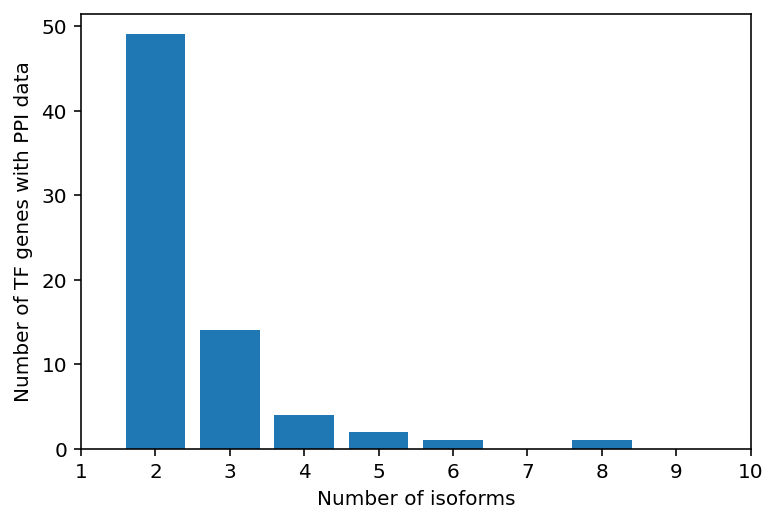

In [96]:
#    - Number of isoforms per TF gene

# remove isoform counts of 1?
n_iso = ppi.groupby('ad_gene_symbol').nunique()['ad_clone_acc']
fig, ax = plt.subplots(1, 1)
ax.bar(n_iso.value_counts().index,
       n_iso.value_counts().values)
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of isoforms')
ax.set_ylabel('Number of TF genes with PPI data')
plt.savefig('../figures/n_isoforms_per_gene_with_ppi_data.pdf',
            bbox_inches='tight')

In [97]:
ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol'].max()

166

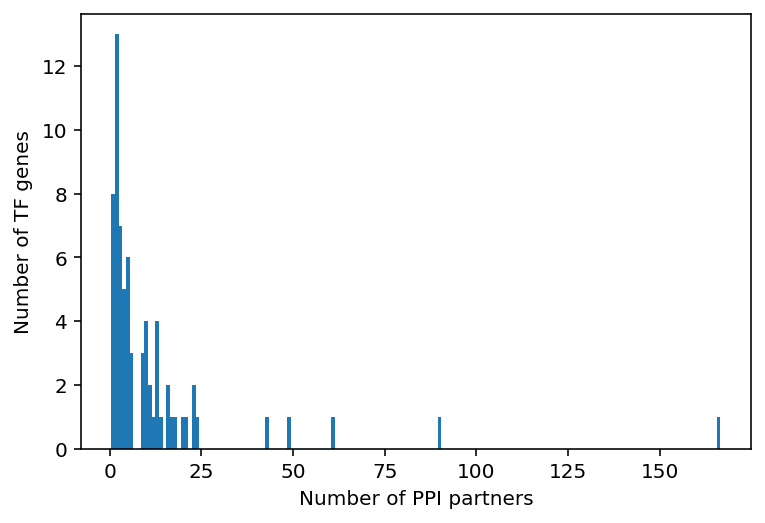

In [98]:
n_ppi = ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes')
plt.savefig('../figures/tf_gene_degree.pdf')

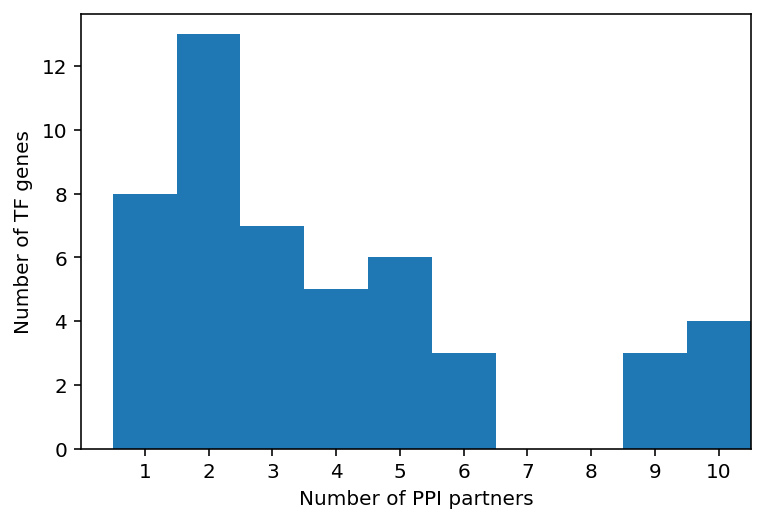

In [99]:
n_ppi = ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes')
ax.set_xlim(0, 10.5)
ax.set_xticks(range(1, 11))
plt.savefig('../figures/tf_gene_degree_zoom.pdf')

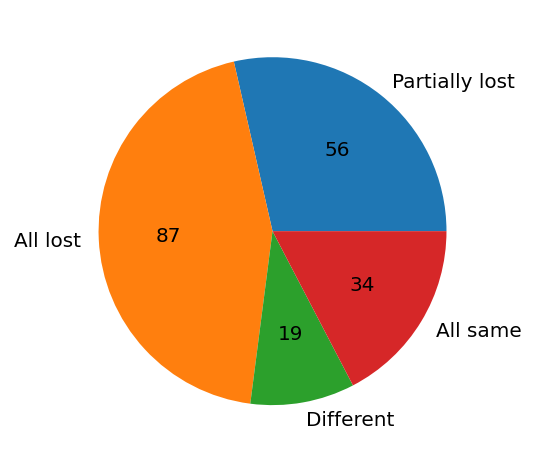

In [112]:
require_at_least_one_ppi_alt_per_isoform = False
ppi_alt = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'score']].copy()
ppi_alt = ppi_alt.loc[ppi_alt.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['score']
                 .transform(lambda row: (row == '1').any()),
              :]
ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_clone_acc')
                  ['score']
                  .transform(lambda x: (x.isin(['0', '1']).any())),
              :]
if require_at_least_one_ppi_alt_per_isoform:
    ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_clone_acc')['score'].transform(lambda x: (x == '1').any()),
                  :]
ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
cats = []
for gene_name in ppi_alt['ad_gene_symbol'].unique():
    tf = ppi_alt.loc[(ppi_alt['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    ref_iso = tf.sum(axis=1).idxmax()
    for iso in tf.index:
        if iso == ref_iso:
            continue
        subset = tf.loc[[ref_iso, iso], 
                        tf.loc[ref_iso, :].notnull() &
                        tf.loc[iso, :].notnull()]    
        if (subset.loc[ref_iso, :] == subset.loc[iso, :]).all():
            cats.append('All same')
        elif subset.loc[iso, subset.columns[subset.loc[ref_iso, :] != True]].any():
            cats.append('Different')
        elif not subset.loc[iso, :].any():
            cats.append('All lost')
        else:
            cats.append('Partially lost')
counts = Counter(cats)
plt.pie(counts.values(),
        labels=counts.keys(),
        autopct=lambda x: '{:.0f}'.format((x / 100.) * sum(counts.values())))
plt.savefig('../figures/alt_isoforms_ppi_alts_pie_inc_no_ppi_alt.pdf',
            bbox_inches='tight')

In [100]:
# classify alternative isoforms by comparing to one with the most interactions
#    (1) all the same 
#    (2) none of those interactions and no others 
#    (3) some of those interactions
#    (4) some additional interactions
# minimum # interactions ?
# this kind-of works but has issues when the ppi with most interacions is tied and there is 

cats = []
for gene_name in ppi['ad_gene_symbol'].unique():
    tf = ppi.loc[(ppi['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    ref_iso = tf.sum(axis=1).idxmax()
    for iso in tf.index:
        if iso == ref_iso:
            continue
        subset = tf.loc[[ref_iso, iso], 
                        tf.loc[ref_iso, :].notnull() &
                        tf.loc[iso, :].notnull()]    
        if (subset.loc[ref_iso, :] == subset.loc[iso, :]).all():
            cats.append('All same')
        elif subset.loc[iso, subset.columns[subset.loc[ref_iso, :] != True]].any():
            cats.append('Different')
        elif not subset.loc[iso, :].any():
            cats.append('All lost')
        else:
            cats.append('Partially lost')


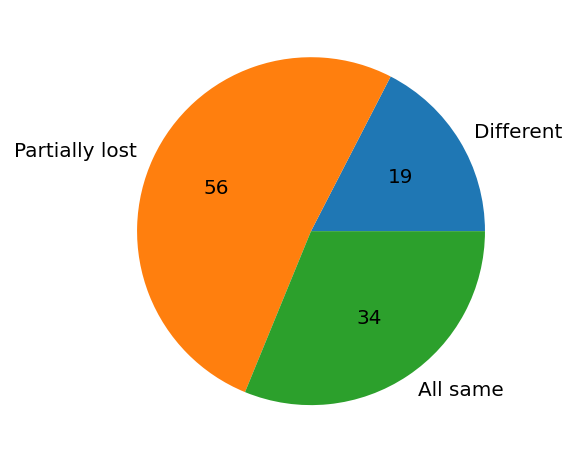

In [101]:
counts = Counter(cats)
plt.pie(counts.values(),
        labels=counts.keys(),
        autopct=lambda x: '{:.0f}'.format((x / 100.) * sum(counts.values())))
plt.savefig('../figures/alt_isoforms_ppis_pie.pdf',
            bbox_inches='tight')

In [102]:
# rewiring fraction
# add category


partners = (ppi.loc[(ppi['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique()).rename('degree_gene_level').to_frame()

df = ppi.copy()
df['score'] = df['score'].map({'1': 1,
                               '0': 0,
                               'AA': np.nan,
                               'NC': np.nan})
# require at least two successful isoform tests per ad gene
df = df.loc[df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['score']
              .transform(lambda x: x.notnull().sum() >= 2),
            :]
partners['rewiring_score'] = 1 - (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                                     ['score'].mean().reset_index().groupby('db_gene_symbol').mean())
partners = partners.dropna(subset=['rewiring_score'])
partners.head()

degree_gene_level  rewiring_score
db_gene_symbol                                   
A1CF                            1        0.500000
ACOT12                          1        0.750000
AEBP2                           1        0.333333
AES                             7        0.369048
AGR2                            1        0.500000

SpearmanrResult(correlation=-0.19278186978613085, pvalue=6.176900285955131e-06)


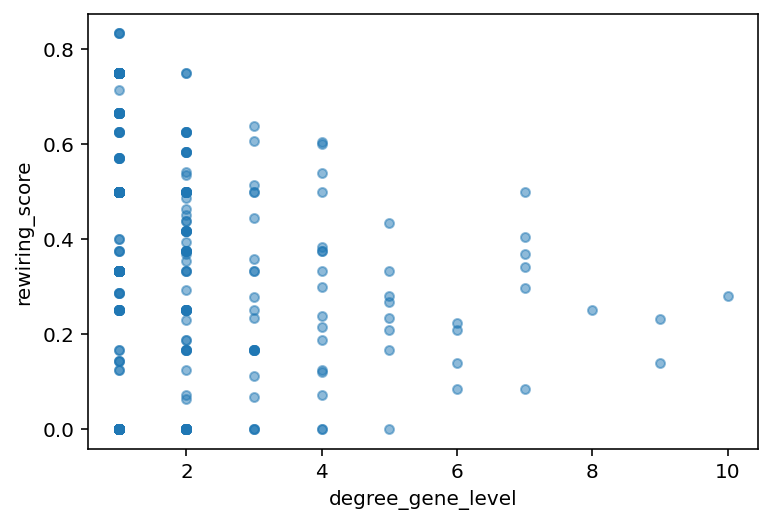

In [103]:

print(stats.spearmanr(partners['degree_gene_level'].values, partners['rewiring_score']))
partners.plot.scatter(x='degree_gene_level', 
                      y='rewiring_score',
                      alpha=0.5)

In [104]:
partners.sort_values('rewiring_score', ascending=False)

degree_gene_level  rewiring_score
db_gene_symbol                                   
SIX1                            1        0.833333
SPO11                           1        0.833333
CRY2                            1        0.833333
LCE2C                           1        0.750000
TRAF3IP3                        1        0.750000
...                           ...             ...
RPL22                           1        0.000000
TNS2                            1        0.000000
TNNT1                           1        0.000000
TNNI2                           1        0.000000
ZSWIM3                          1        0.000000

[542 rows x 2 columns]

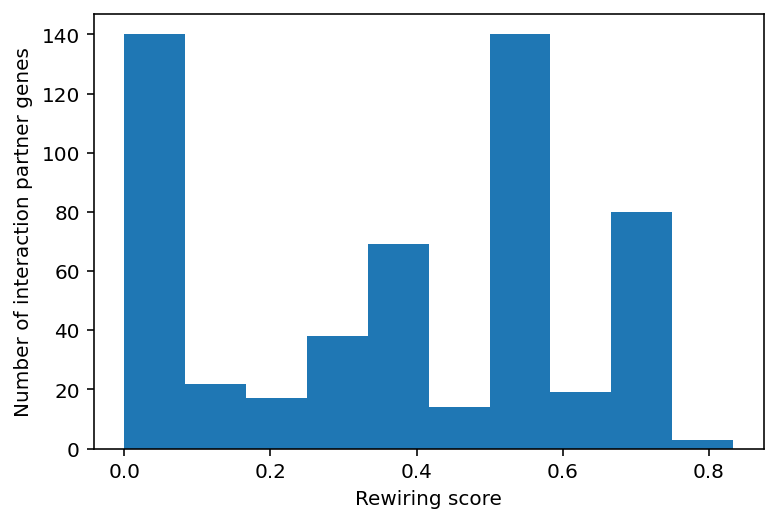

In [105]:
fig, ax = plt.subplots(1, 1)
partners['rewiring_score'].plot.hist()
ax.set_xlabel('Rewiring score')
ax.set_ylabel('Number of interaction partner genes')
plt.savefig('../figures/rewiring_dist.pdf',
            bbox_inches='tight')

In [106]:
partner_cats = load_ppi_partner_categories()
partner_cats.head()

partner  category cofactor_type
0  CITED2  cofactor          both
1    DPF2  cofactor          both
2    EMSY  cofactor          both
3    FHL2  cofactor          both
4      HR  cofactor          both

In [107]:
cats = partner_cats.groupby('category')['partner'].apply(set).to_dict()
for cat, members in cats.items():
    partners['is_' + '_'.join(cat.split())] = partners.index.isin(members)

In [108]:
for col in partners.columns:
    if col.startswith('is_'):
        print(col)
        print(stats.mannwhitneyu(partners.loc[partners[col], 'rewiring_score'].values,
                                 partners.loc[~partners[col], 'rewiring_score'].values))

is_DNA_polymerase
MannwhitneyuResult(statistic=651.0, pvalue=0.27765939169545945)
is_DNA_repair
MannwhitneyuResult(statistic=4092.5, pvalue=0.4249013378290839)
is_DNA_replication
MannwhitneyuResult(statistic=519.0, pvalue=0.4624615498913629)
is_RNA_processing
MannwhitneyuResult(statistic=7410.0, pvalue=0.12473941718494491)
is_RNA_turnover
MannwhitneyuResult(statistic=898.0, pvalue=0.02937919953752668)
is_TF
MannwhitneyuResult(statistic=26253.0, pvalue=0.05565398369912887)
is_cell_cycle
MannwhitneyuResult(statistic=5518.0, pvalue=0.38797685898624273)
is_cell-cell_signaling
MannwhitneyuResult(statistic=1921.0, pvalue=0.14907713626596497)
is_cofactor
MannwhitneyuResult(statistic=18074.5, pvalue=0.05849534156206088)
is_cytoskeleton
MannwhitneyuResult(statistic=8943.5, pvalue=0.4271783343585338)
is_membrane_protein
MannwhitneyuResult(statistic=735.5, pvalue=0.3926710841613553)
is_metabolism
MannwhitneyuResult(statistic=5764.0, pvalue=0.10924678202297078)
is_nuclear_transport
MannwhitneyuRes

/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [109]:
hiu = huri.load_nw_hi_union(id_type='ensembl_gene_id')
lit = huri.load_nw_lit_17(id_type='ensembl_gene_id')
litb = lit.loc[lit['category'].isin(['Lit-BM', 'Lit-BS']), :].copy()
litbm = lit.loc[lit['category'].isin(['Lit-BM']), :].copy()

def map_gene_names(nw):
    return set(huri.map_nw_ids(nw, 'ensembl_gene_id', 'hgnc_symbol').index)

hiu = map_gene_names(hiu)
lit = map_gene_names(lit)
litbm = map_gene_names(litbm)
litb = map_gene_names(litb)

/Users/lukelambourne/Work/ccsblib/ccsblib/utils.py:317: UserWarning: Warning: loading data failed.
  warnings.warn('Warning: loading data failed.')
/Users/lukelambourne/Work/ccsblib/ccsblib/utils.py:320: UserWarning: Warning: Reading from cache
  warnings.warn('Warning: Reading from cache')


Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?
Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?
Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?
Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?


In [110]:
new_ppis = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['score'] == '1'),
                        ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
new_ppis = set((new_ppis[['ad_gene_symbol', 'db_gene_symbol']].min(axis=1) + '_' +
               new_ppis[['ad_gene_symbol', 'db_gene_symbol']].max(axis=1)).drop_duplicates().values)

In [111]:
print('Total number of PPIs at isoform-level: {}'
        .format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['score'] == '1'), ].shape[0]))
print('Gene-gene PPIs: {}'.format(len(new_ppis)))
print('Not in HI-Union: {}'.format(len(new_ppis.difference(hiu))))
print('Not in HI-Union or Lit-BM: {}'.format(len(new_ppis.difference(hiu.union(litbm)))))
print('Not in HI-Union or Lit-B: {}'.format(len(new_ppis.difference(hiu.union(litb)))))
print('Not in HI-Union or Lit-NB: {}'.format(len(new_ppis.difference(hiu.union(lit)))))

Total number of PPIs at isoform-level: 2545
Gene-gene PPIs: 1417
Not in HI-Union: 585
Not in HI-Union or Lit-BM: 574
Not in HI-Union or Lit-B: 572
Not in HI-Union or Lit-NB: 542
